In [149]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing & Model Selection
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.impute import SimpleImputer

# Feature Selection
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.decomposition import PCA

# Classifier
from sklearn.svm import SVC

# Metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
import warnings

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

print("Library berhasil dimuat.")

Library berhasil dimuat.


In [150]:
csv_path = "features_ABCD_final.csv"

try:
    df = pd.read_csv(csv_path)
    print(f"Data berhasil dimuat. Dimensi: {df.shape}")
except FileNotFoundError:
    print("File CSV tidak ditemukan! Pastikan path sudah benar.")

# 1. Cek data awal
display(df.head())

# Drop kolom yang tidak diperlukan untuk training (ID Gambar)
if 'image_id' in df.columns:
    df_clean = df.drop(columns=['image_id'])
else:
    df_clean = df.copy()

# Handling NaN
df_clean.replace([np.inf, -np.inf], np.nan, inplace=True)
df_clean.fillna(df_clean.mean(numeric_only=True), inplace=True)

print("Pembersihan dasar selesai.")

Data berhasil dimuat. Dimensi: (900, 67)


,image_id,label,asym_total,hu_0,hu_1,hu_2,hu_3,hu_4,hu_5,hu_6,...,hist_S_bin_6,hist_S_bin_7,hist_V_bin_0,hist_V_bin_1,hist_V_bin_2,hist_V_bin_3,hist_V_bin_4,hist_V_bin_5,hist_V_bin_6,hist_V_bin_7
0,ISIC_0000000,benign,83.039185,0.743542,2.223596,3.435788,4.660064,8.822681,5.911811,-8.901430,...,0.000000,0.0,0.011723,0.671528,0.626297,0.384132,0.095434,0.000000,0.000000,0.000000
1,ISIC_0000001,benign,36.319019,0.790259,3.549854,4.679815,6.746186,-12.499489,-8.553580,-12.844740,...,0.000387,0.0,0.100348,0.637708,0.579102,0.487169,0.102788,0.000000,0.000000,0.000000
2,ISIC_0000002,malignant,106.312622,0.763794,2.637882,4.156524,5.769245,-10.831865,-7.195010,-10.949045,...,0.000000,0.0,0.000000,0.005905,0.091854,0.681499,0.725999,0.003404,0.000000,0.000000
3,ISIC_0000004,malignant,4.043910,0.798106,5.426662,6.421425,10.301523,-18.735945,-13.109289,18.935321,...,0.001036,0.0,0.000000,0.000000,0.000196,0.034210,0.110339,0.550311,0.707733,0.427699
4,ISIC_0000006,benign,91.804058,0.764130,2.601060,4.281884,5.836904,12.930099,7.409075,-10.896317,...,0.000000,0.0,0.000000,0.000000,0.075614,0.996665,0.030678,0.000000,0.000000,0.000000


Pembersihan dasar selesai.


In [171]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 67 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   image_id            900 non-null    object 
 1   label               900 non-null    object 
 2   asym_total          900 non-null    float64
 3   hu_0                900 non-null    float64
 4   hu_1                900 non-null    float64
 5   hu_2                900 non-null    float64
 6   hu_3                900 non-null    float64
 7   hu_4                900 non-null    float64
 8   hu_5                900 non-null    float64
 9   hu_6                900 non-null    float64
 10  hog_mean            900 non-null    float64
 11  hog_var             900 non-null    float64
 12  solidity            900 non-null    float64
 13  convexity           900 non-null    float64
 14  fractal_dim         900 non-null    float64
 15  std_R               900 non-null    float64
 16  std_G   

In [152]:
df.describe()

,asym_total,hu_0,hu_1,hu_2,hu_3,hu_4,hu_5,hu_6,hog_mean,hog_var,...,hist_S_bin_6,hist_S_bin_7,hist_V_bin_0,hist_V_bin_1,hist_V_bin_2,hist_V_bin_3,hist_V_bin_4,hist_V_bin_5,hist_V_bin_6,hist_V_bin_7
count,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,...,900.000000,900.000000,900.000000,9.000000e+02,9.000000e+02,900.000000,900.000000,900.000000,900.000000,900.000000
mean,86.942483,0.734980,2.605915,3.987908,5.397372,2.029671,0.850144,-0.490931,0.038078,0.010868,...,0.077736,0.022632,0.006368,3.567550e-02,9.000280e-02,0.202777,0.381195,0.454481,0.247139,0.082765
std,59.536092,0.063245,0.633020,1.393642,1.628041,10.643161,7.160119,10.862012,0.014111,0.003183,...,0.176775,0.101038,0.052113,1.280169e-01,1.824806e-01,0.262476,0.332680,0.355382,0.344562,0.230814
min,0.000000,0.322776,0.971217,0.000000,0.000000,-21.258682,-33.961870,-63.738632,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,45.647527,0.722678,2.220010,3.324889,4.561918,-9.849853,-7.021056,-10.324912,0.034426,0.010704,...,0.000015,0.000000,0.000000,0.000000e+00,6.623361e-07,0.000519,0.036982,0.093825,0.000058,0.000000
50%,75.609563,0.752630,2.539316,3.855926,5.338695,7.906863,5.146128,-6.869749,0.039693,0.011663,...,0.002134,0.000018,0.000000,5.816897e-08,9.173802e-04,0.046824,0.345396,0.430225,0.015768,0.000014
75%,116.636964,0.775337,2.939887,4.479725,6.200795,10.473398,6.881299,10.232639,0.046194,0.012589,...,0.051367,0.001023,0.000000,1.781024e-03,6.483922e-02,0.359710,0.674547,0.791468,0.468454,0.001355
max,384.145414,0.798158,6.128988,31.685930,31.904921,64.096071,13.104083,21.697371,0.085926,0.017698,...,0.936509,0.985938,0.818053,9.538355e-01,9.132790e-01,0.996665,0.999539,0.999999,0.999996,1.000000


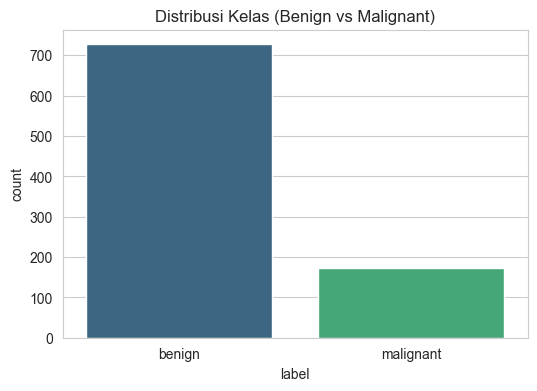

Jumlah per kelas:
label
benign       727
malignant    173
Name: count, dtype: int64


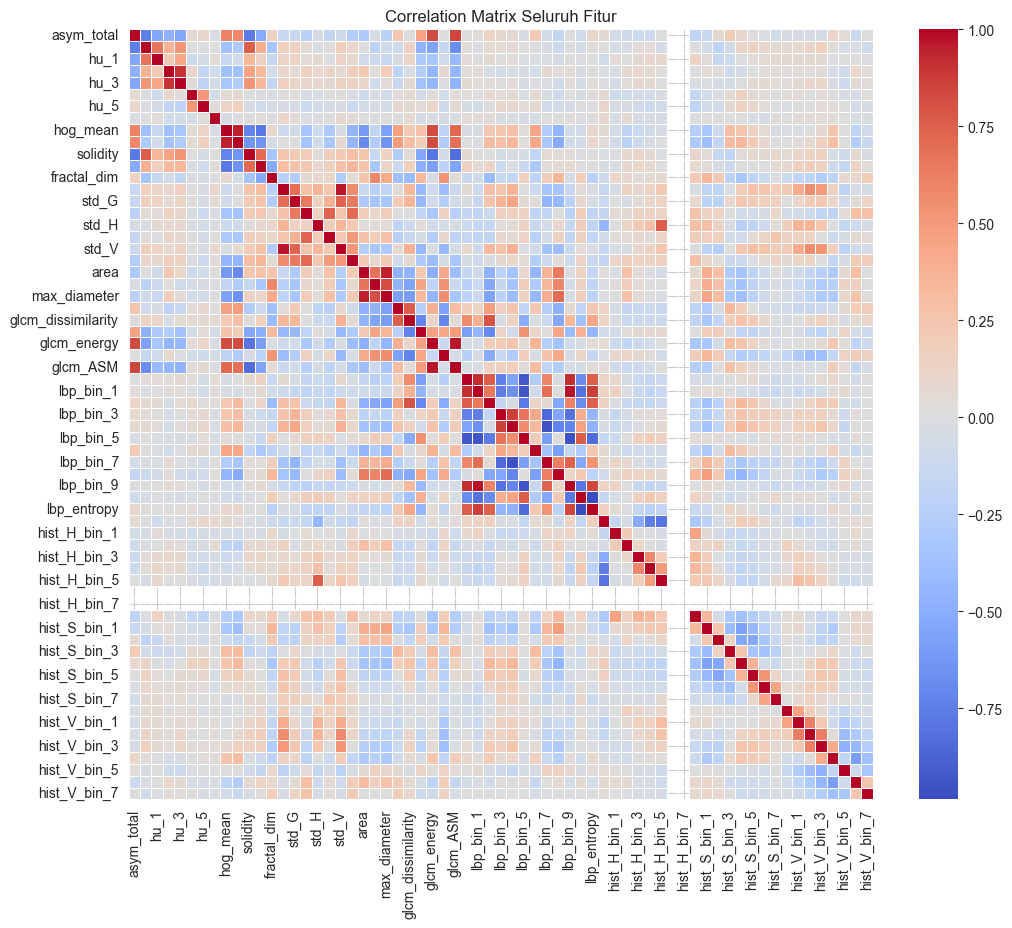

In [153]:
# Cek Distribusi Kelas (Benign vs Malignant)
plt.figure(figsize=(6, 4))
sns.countplot(x='label', data=df_clean, palette='viridis')
plt.title("Distribusi Kelas (Benign vs Malignant)")
plt.show()

print("Jumlah per kelas:")
print(df_clean['label'].value_counts())

# Cek Korelasi Fitur
# Ambil kolom numerik saja
numeric_cols = df_clean.select_dtypes(include=[np.number]).columns
correlation_matrix = df_clean[numeric_cols].corr()

plt.figure(figsize=(12, 10))
# Plot heatmap korelasi
sns.heatmap(correlation_matrix, cmap='coolwarm', linewidths=0.5, annot=False)
plt.title("Correlation Matrix Seluruh Fitur")
plt.show()

In [154]:
# Encode Label (String -> Angka)
# benign -> 0, malignant -> 1 
le = LabelEncoder()
df_clean['label_encoded'] = le.fit_transform(df_clean['label'])

# Pisahkan X dan y
X = df_clean.drop(columns=['label', 'label_encoded'])
y = df_clean['label_encoded']

print(f"Mapping Label: {dict(zip(le.classes_, le.transform(le.classes_)))}")

# Split Data (80% Train, 20% Test)
# Stratify=y penting agar proporsi benign/malignant di test set sama dengan train set
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Dimensi Train: {X_train_raw.shape}")
print(f"Dimensi Test:  {X_test_raw.shape}")

Mapping Label: {'benign': np.int64(0), 'malignant': np.int64(1)}
Dimensi Train: (720, 65)
Dimensi Test:  (180, 65)


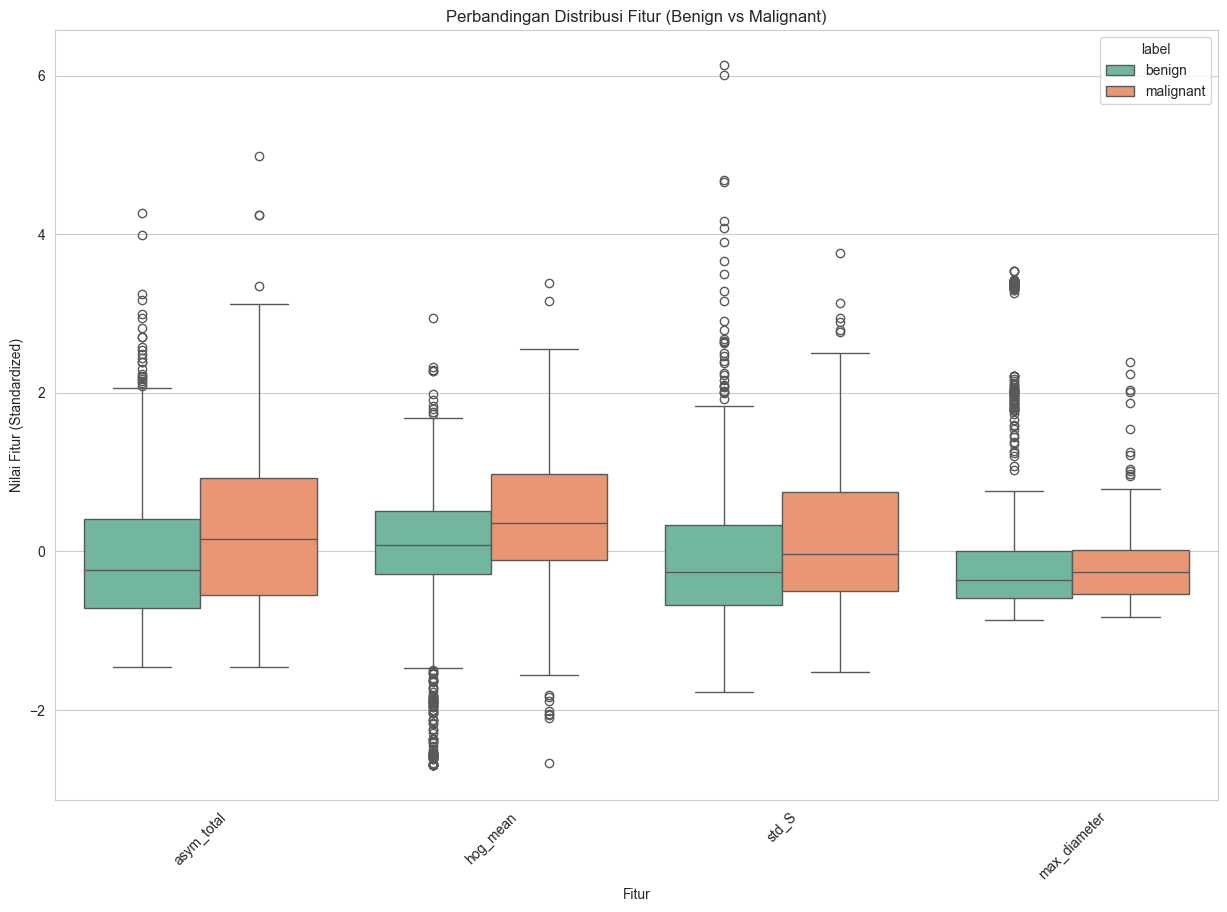

In [155]:
import seaborn as sns
import matplotlib.pyplot as plt

# Pastikan menggunakan df_clean yang sudah di-load sebelumnya
# Filter hanya kolom numerik untuk plotting
numeric_features = df_clean.select_dtypes(include=[np.number]).columns.tolist()
# Hapus kolom label dari list fitur
features_to_plot = [f for f in numeric_features if f not in ['label_encoded', 'label']]

# Kita plot fitur-fitur kunci ABCD
key_features = [
    'asym_total', 'hog_mean',       # Asymmetry / Texture
    'border_roughness', 'fractal_dimension', # Border
    'std_S', 'entropy_L',           # Color
    'color_cluster_spread', 'max_diameter' # Color / Diameter
]

# Cek apakah fitur tersebut ada di dataframe (untuk menghindari error)
valid_features = [f for f in key_features if f in df_clean.columns]

plt.figure(figsize=(15, 10))
# Gunakan Melt untuk format data agar bisa di-plot seaborn sekaligus
df_melted = df_clean.melt(id_vars='label', value_vars=valid_features, 
                          var_name='Fitur', value_name='Nilai')

# Standardisasi nilai agar skalanya mirip saat di-plot (Z-score)
# Ini hanya visualisasi, tidak mengubah data asli
df_melted['Nilai_Scaled'] = df_melted.groupby('Fitur')['Nilai'].transform(lambda x: (x - x.mean()) / x.std())

sns.boxplot(data=df_melted, x='Fitur', y='Nilai_Scaled', hue='label', palette='Set2')
plt.title("Perbandingan Distribusi Fitur (Benign vs Malignant)")
plt.xticks(rotation=45)
plt.ylabel("Nilai Fitur (Standardized)")
plt.show()

# ANALISIS MANUAL:
# Lihat kotak (box). Jika kotak hijau (Benign) dan oranye (Malignant) sejajar, 
# berarti fitur itu LEMAH. Kita cari yang kotaknya terpisah jauh (misal satu di atas, satu di bawah).

Sedang menjalankan t-SNE...


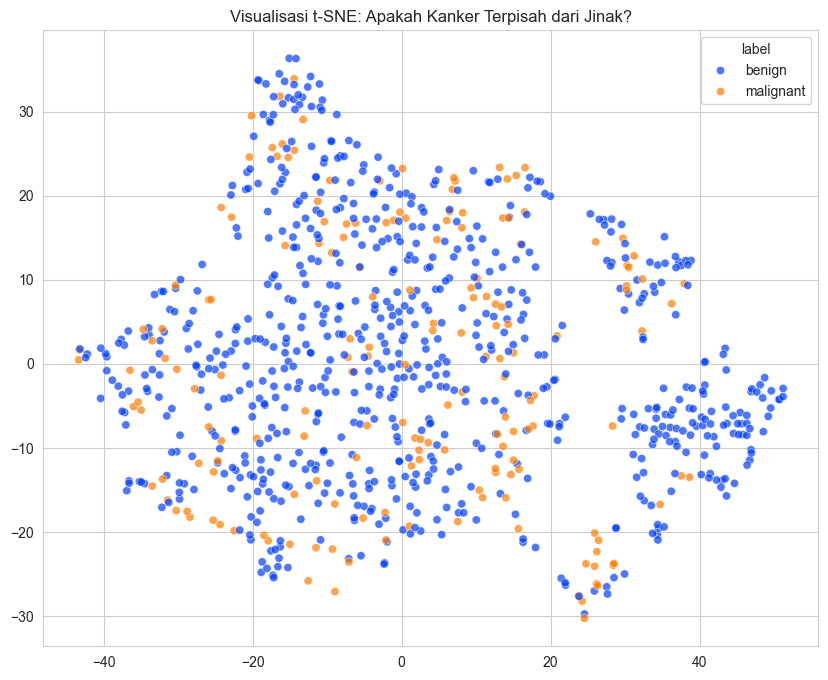

In [156]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

print("Sedang menjalankan t-SNE...")

# Ambil fitur dan label
X_tsne = df_clean.drop(columns=['label', 'label_encoded'])
y_tsne = df_clean['label']

# Scale dulu (Wajib untuk t-SNE)
scaler = StandardScaler()
X_scaled_tsne = scaler.fit_transform(X_tsne)

# Jalankan t-SNE (perplexity 30 biasanya standar bagus)
tsne = TSNE(n_components=2, perplexity=30, random_state=42, init='pca', learning_rate='auto')
X_embedded = tsne.fit_transform(X_scaled_tsne)

# Plotting
plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], hue=y_tsne, palette='bright', alpha=0.7)
plt.title("Visualisasi t-SNE: Apakah Kanker Terpisah dari Jinak?")
plt.show()

In [157]:
print("--- SKENARIO 1: CHI-SQUARE + SVM ---")

# A. Scaling (MinMax Wajib untuk Chi2 karena tidak boleh ada nilai negatif)
scaler_minmax = MinMaxScaler()
X_train_minmax = scaler_minmax.fit_transform(X_train_raw)
X_test_minmax = scaler_minmax.transform(X_test_raw)

# B. Feature Selection (Select K Best)
# Misal kita ingin mengambil 10 fitur terbaik yang paling berpengaruh
k_features = 10
chi2_selector = SelectKBest(chi2, k=k_features)

X_train_chi2 = chi2_selector.fit_transform(X_train_minmax, y_train)
X_test_chi2 = chi2_selector.transform(X_test_minmax)

# Tampilkan Fitur yang terpilih
mask = chi2_selector.get_support()
selected_features_chi2 = X.columns[mask]
print(f"\n{k_features} Fitur Terbaik menurut Chi-Square:")
for f in selected_features_chi2:
    print(f"- {f}")

# C. Klasifikasi SVM
svm_chi2 = SVC(kernel='rbf', C=1.0, gamma='scale', probability=True, random_state=42, class_weight='balanced')
svm_chi2.fit(X_train_chi2, y_train)

# D. Prediksi
y_pred_chi2 = svm_chi2.predict(X_test_chi2)

# Evaluasi
acc_chi2 = accuracy_score(y_test, y_pred_chi2)
print(f"\nAkurasi Chi-Square + SVM: {acc_chi2:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_chi2, target_names=le.classes_))

--- SKENARIO 1: CHI-SQUARE + SVM ---

10 Fitur Terbaik menurut Chi-Square:
- std_H
- std_V
- area
- glcm_ASM
- hist_H_bin_3
- hist_H_bin_4
- hist_H_bin_5
- hist_S_bin_0
- hist_V_bin_1
- hist_V_bin_2

Akurasi Chi-Square + SVM: 0.7778

Classification Report:
              precision    recall  f1-score   support

      benign       0.87      0.86      0.86       145
   malignant       0.43      0.46      0.44        35

    accuracy                           0.78       180
   macro avg       0.65      0.66      0.65       180
weighted avg       0.78      0.78      0.78       180



In [158]:
print("--- SKENARIO 2: PCA + SVM ---")

# Scaling
scaler_std = StandardScaler()
X_train_std = scaler_std.fit_transform(X_train_raw)
X_test_std = scaler_std.transform(X_test_raw)

# Feature Extraction (PCA)
# PCA mempertahankan 95% informasi (variance) dari data asli
pca = PCA(n_components=0.95, random_state=42)

X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

print(f"\nJumlah fitur asli: {X.shape[1]}")
print(f"Jumlah komponen PCA (95% variance): {pca.n_components_}")

# C. Klasifikasi SVM
svm_pca = SVC(kernel='rbf', C=1.0, gamma='scale', probability=True, random_state=42, class_weight='balanced')
svm_pca.fit(X_train_pca, y_train)

# D. Prediksi
y_pred_pca = svm_pca.predict(X_test_pca)

# Evaluasi
acc_pca = accuracy_score(y_test, y_pred_pca)
print(f"\nAkurasi PCA + SVM: {acc_pca:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_pca, target_names=le.classes_))

--- SKENARIO 2: PCA + SVM ---

Jumlah fitur asli: 65
Jumlah komponen PCA (95% variance): 29

Akurasi PCA + SVM: 0.7056

Classification Report:
              precision    recall  f1-score   support

      benign       0.85      0.77      0.81       145
   malignant       0.32      0.46      0.38        35

    accuracy                           0.71       180
   macro avg       0.59      0.61      0.59       180
weighted avg       0.75      0.71      0.72       180



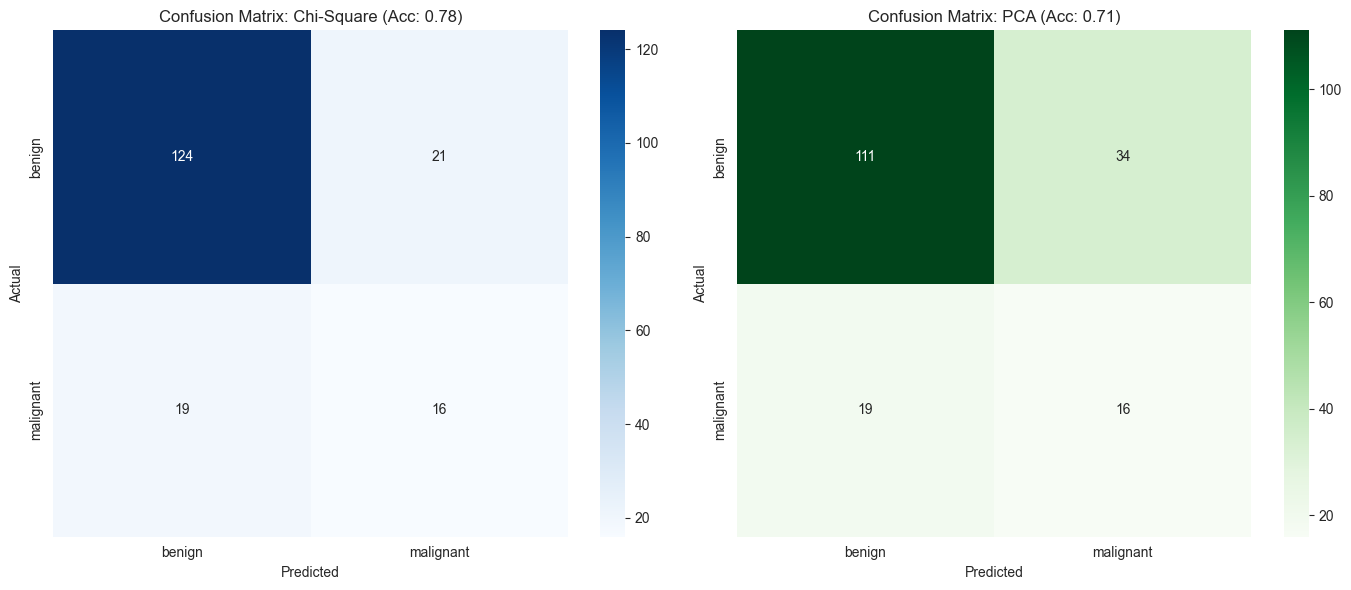

KESIMPULAN PERFORMA
Akurasi menggunakan Chi-Square (Top 10 Fitur): 77.78%
Akurasi menggunakan PCA (29 Komponen):   70.56%

Metode Chi-Square memberikan hasil lebih baik pada dataset ini.


In [159]:
# Visualisasi Confusion Matrix Side-by-Side

fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# 1. Heatmap Chi-Square
cm_chi2 = confusion_matrix(y_test, y_pred_chi2)
sns.heatmap(cm_chi2, annot=True, fmt='d', cmap='Blues', ax=ax[0], 
            xticklabels=le.classes_, yticklabels=le.classes_)
ax[0].set_title(f'Confusion Matrix: Chi-Square (Acc: {acc_chi2:.2f})')
ax[0].set_xlabel('Predicted')
ax[0].set_ylabel('Actual')

# 2. Heatmap PCA
cm_pca = confusion_matrix(y_test, y_pred_pca)
sns.heatmap(cm_pca, annot=True, fmt='d', cmap='Greens', ax=ax[1],
            xticklabels=le.classes_, yticklabels=le.classes_)
ax[1].set_title(f'Confusion Matrix: PCA (Acc: {acc_pca:.2f})')
ax[1].set_xlabel('Predicted')
ax[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()

# Kesimpulan Sederhana
print("="*50)
print("KESIMPULAN PERFORMA")
print("="*50)
print(f"Akurasi menggunakan Chi-Square (Top {k_features} Fitur): {acc_chi2:.2%}")
print(f"Akurasi menggunakan PCA ({pca.n_components_} Komponen):   {acc_pca:.2%}")

if acc_pca > acc_chi2:
    print("\nMetode PCA memberikan hasil lebih baik pada dataset ini.")
elif acc_chi2 > acc_pca:
    print("\nMetode Chi-Square memberikan hasil lebih baik pada dataset ini.")
else:
    print("\nKedua metode memberikan hasil yang sama.")

In [160]:
from imblearn.over_sampling import SMOTE
from collections import Counter

# 1. Encode Label
le = LabelEncoder()
df_clean['label_encoded'] = le.fit_transform(df_clean['label'])

X = df_clean.drop(columns=['label', 'label_encoded'])
y = df_clean['label_encoded']

# 2. Split Data (Stratified)
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Original Train shape: {Counter(y_train)}")
print(f"Original Test shape:  {Counter(y_test)}")

# 3. APPLY SMOTE (Hanya ke Training Data)
print("\nMelakukan SMOTE Oversampling...")
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_raw, y_train)

print(f"Resampled Train shape: {Counter(y_train_smote)}")
print("(Sekarang jumlah benign dan malignant di training set seimbang)")

Original Train shape: Counter({0: 582, 1: 138})
Original Test shape:  Counter({0: 145, 1: 35})

Melakukan SMOTE Oversampling...
Resampled Train shape: Counter({1: 582, 0: 582})
(Sekarang jumlah benign dan malignant di training set seimbang)


--- SKENARIO 1: CHI-SQUARE + SVM (DENGAN SMOTE) ---

Fitur Terpilih: ['std_H', 'std_V', 'area', 'glcm_ASM', 'hist_H_bin_3', 'hist_H_bin_4', 'hist_H_bin_5', 'hist_S_bin_0', 'hist_V_bin_1', 'hist_V_bin_2']

Classification Report:
              precision    recall  f1-score   support

      benign       0.85      0.82      0.84       145
   malignant       0.35      0.40      0.37        35

    accuracy                           0.74       180
   macro avg       0.60      0.61      0.60       180
weighted avg       0.75      0.74      0.75       180



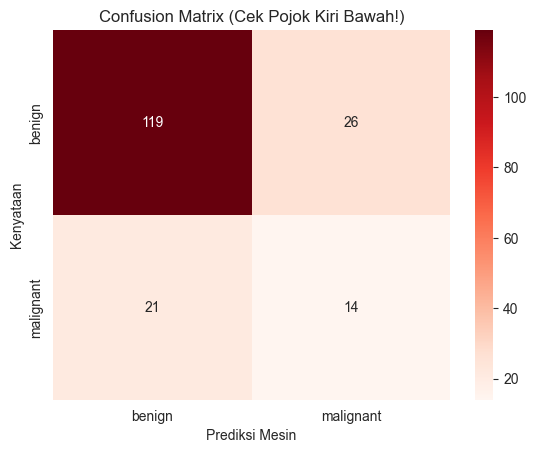

In [161]:
print("--- SKENARIO 1: CHI-SQUARE + SVM (DENGAN SMOTE) ---")

# A. Scaling (Gunakan data hasil SMOTE)
scaler_minmax = MinMaxScaler()
# Fit pada data SMOTE
X_train_minmax = scaler_minmax.fit_transform(X_train_smote) 
# Transform test data asli (jangan pakai data smote untuk test)
X_test_minmax = scaler_minmax.transform(X_test_raw)

# B. Feature Selection
k_features = 10
chi2_selector = SelectKBest(chi2, k=k_features)

X_train_chi2 = chi2_selector.fit_transform(X_train_minmax, y_train_smote)
X_test_chi2 = chi2_selector.transform(X_test_minmax)

mask = chi2_selector.get_support()
print(f"\nFitur Terpilih: {list(X.columns[mask])}")

# C. Klasifikasi SVM
# Kita tetap pasang class_weight='balanced' sebagai pengaman ganda, 
# meskipun data training sudah seimbang berkat SMOTE.
svm_chi2 = SVC(kernel='rbf', C=1.0, 
               class_weight='balanced', # <--- Best Practice
               gamma='scale', probability=True, random_state=42)

svm_chi2.fit(X_train_chi2, y_train_smote)

# D. Prediksi
y_pred_chi2 = svm_chi2.predict(X_test_chi2)

# Evaluasi Fokus ke Recall/F1-Score
print("\nClassification Report:")
print(classification_report(y_test, y_pred_chi2, target_names=le.classes_))

# Cek Confusion Matrix untuk melihat False Negative (Kanker yang dibilang sehat)
cm = confusion_matrix(y_test, y_pred_chi2)
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix (Cek Pojok Kiri Bawah!)")
plt.xlabel("Prediksi Mesin")
plt.ylabel("Kenyataan")
plt.show()

--- SKENARIO 2: PCA + SVM (DENGAN SMOTE) ---

Jumlah fitur awal: 65
Jumlah komponen PCA (terpilih): 29
Variance ratio yang dijelaskan: 95.45%

Classification Report (PCA + SMOTE):
              precision    recall  f1-score   support

      benign       0.83      0.81      0.82       145
   malignant       0.28      0.31      0.30        35

    accuracy                           0.71       180
   macro avg       0.56      0.56      0.56       180
weighted avg       0.72      0.71      0.72       180



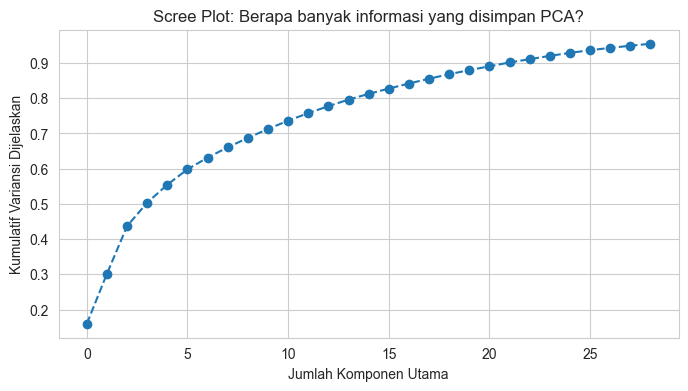

In [162]:
print("--- SKENARIO 2: PCA + SVM (DENGAN SMOTE) ---")

# 1. Scaling (StandardScaler WAJIB untuk PCA)
# PENTING: Kita melakukan fit pada data TRAINING HASIL SMOTE
scaler_std = StandardScaler()

# Fit & Transform pada data Training SMOTE
X_train_std = scaler_std.fit_transform(X_train_smote) 

# Transform pada data Test Asli (JANGAN di-fit ulang, pakai parameter dari train)
X_test_std = scaler_std.transform(X_test_raw)

# 2. Feature Extraction (PCA)
# Kita minta PCA mempertahankan 95% variansi data
pca = PCA(n_components=0.95, random_state=42)

# Fit PCA pada data Training SMOTE yang sudah diskalakan
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

print(f"\nJumlah fitur awal: {X.shape[1]}")
print(f"Jumlah komponen PCA (terpilih): {pca.n_components_}")
print(f"Variance ratio yang dijelaskan: {np.sum(pca.explained_variance_ratio_):.2%}")

# 3. Klasifikasi SVM
# Kita tetap gunakan class_weight='balanced' sebagai pengaman tambahan
svm_pca = SVC(kernel='rbf', C=1.0, 
              class_weight='balanced', 
              gamma='scale', probability=True, random_state=42)

# Train model menggunakan data hasil proyeksi PCA dari SMOTE
svm_pca.fit(X_train_pca, y_train_smote)

# 4. Prediksi
y_pred_pca = svm_pca.predict(X_test_pca)

# 5. Evaluasi
print("\nClassification Report (PCA + SMOTE):")
print(classification_report(y_test, y_pred_pca, target_names=le.classes_))

# Visualisasi Scree Plot (Opsional - untuk melihat seberapa penting tiap komponen)
plt.figure(figsize=(8, 4))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--')
plt.xlabel('Jumlah Komponen Utama')
plt.ylabel('Kumulatif Variansi Dijelaskan')
plt.title('Scree Plot: Berapa banyak informasi yang disimpan PCA?')
plt.grid(True)
plt.show()

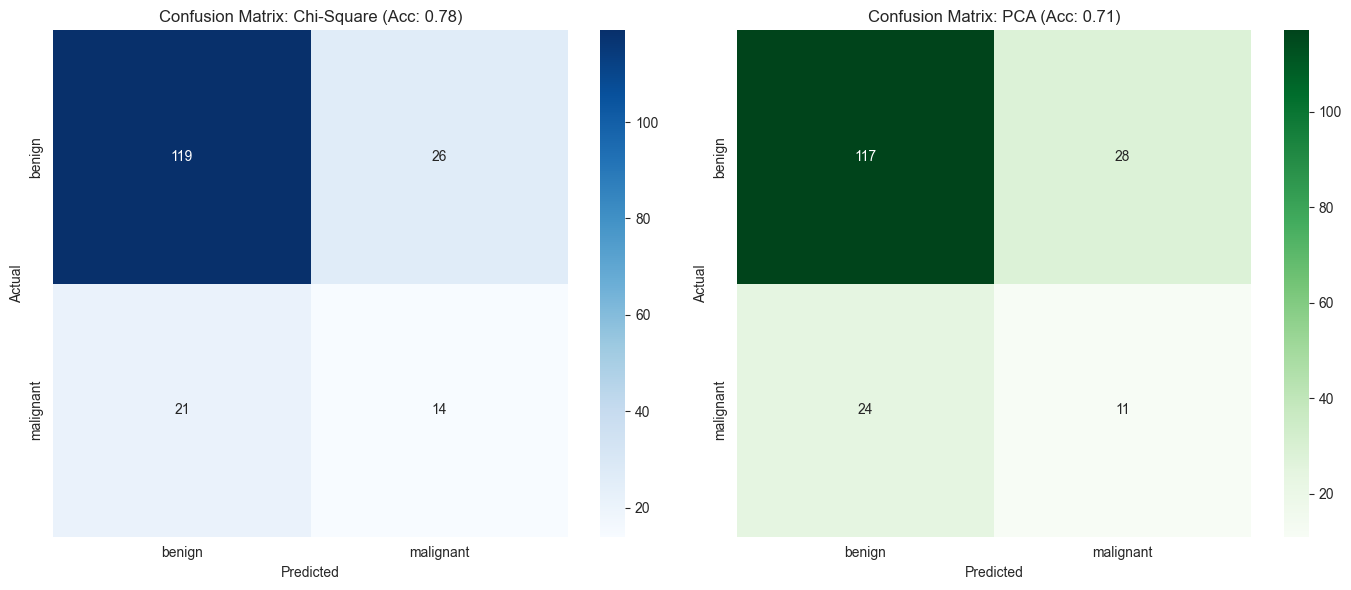

KESIMPULAN PERFORMA
Akurasi menggunakan Chi-Square (Top 10 Fitur): 77.78%
Akurasi menggunakan PCA (29 Komponen):   70.56%

Metode Chi-Square memberikan hasil lebih baik pada dataset ini.


In [163]:
# Visualisasi Confusion Matrix Side-by-Side

fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# 1. Heatmap Chi-Square
cm_chi2 = confusion_matrix(y_test, y_pred_chi2)
sns.heatmap(cm_chi2, annot=True, fmt='d', cmap='Blues', ax=ax[0], 
            xticklabels=le.classes_, yticklabels=le.classes_)
ax[0].set_title(f'Confusion Matrix: Chi-Square (Acc: {acc_chi2:.2f})')
ax[0].set_xlabel('Predicted')
ax[0].set_ylabel('Actual')

# 2. Heatmap PCA
cm_pca = confusion_matrix(y_test, y_pred_pca)
sns.heatmap(cm_pca, annot=True, fmt='d', cmap='Greens', ax=ax[1],
            xticklabels=le.classes_, yticklabels=le.classes_)
ax[1].set_title(f'Confusion Matrix: PCA (Acc: {acc_pca:.2f})')
ax[1].set_xlabel('Predicted')
ax[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()

# Kesimpulan Sederhana
print("="*50)
print("KESIMPULAN PERFORMA")
print("="*50)
print(f"Akurasi menggunakan Chi-Square (Top {k_features} Fitur): {acc_chi2:.2%}")
print(f"Akurasi menggunakan PCA ({pca.n_components_} Komponen):   {acc_pca:.2%}")

if acc_pca > acc_chi2:
    print("\nMetode PCA memberikan hasil lebih baik pada dataset ini.")
elif acc_chi2 > acc_pca:
    print("\nMetode Chi-Square memberikan hasil lebih baik pada dataset ini.")
else:
    print("\nKedua metode memberikan hasil yang sama.")

--- SKENARIO 3: SVM FULL FEATURES (BASELINE) ---
(Menggunakan seluruh fitur tanpa pengurangan dimensi)

Jumlah fitur yang digunakan: 65 (Semua Fitur)

Akurasi SVM Full Features: 0.7111

Classification Report:
              precision    recall  f1-score   support

      benign       0.83      0.81      0.82       145
   malignant       0.27      0.29      0.28        35

    accuracy                           0.71       180
   macro avg       0.55      0.55      0.55       180
weighted avg       0.72      0.71      0.71       180



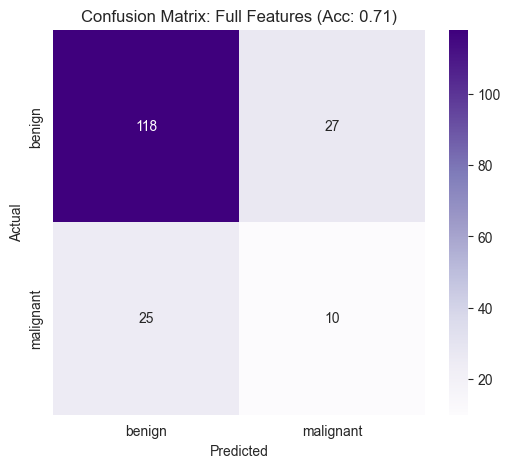

In [164]:
print("--- SKENARIO 3: SVM FULL FEATURES (BASELINE) ---")
print("(Menggunakan seluruh fitur tanpa pengurangan dimensi)")

# 1. Scaling (StandardScaler)
# Kita tetap butuh scaling karena range nilai fitur berbeda-beda (misal: Area ribuan, tapi Rasio 0-1)
scaler_full = StandardScaler()

# Fit pada Training Data (SMOTE)
X_train_scaled_full = scaler_full.fit_transform(X_train_smote)
X_test_scaled_full = scaler_full.transform(X_test_raw)

print(f"\nJumlah fitur yang digunakan: {X_train_scaled_full.shape[1]} (Semua Fitur)")

# 2. Training SVM
svm_full = SVC(kernel='rbf', C=1.0, 
               class_weight='balanced', # Wajib untuk imbalance data
               gamma='scale', probability=True, random_state=42)

svm_full.fit(X_train_scaled_full, y_train_smote)

# 3. Prediksi
y_pred_full = svm_full.predict(X_test_scaled_full)

# 4. Evaluasi
acc_full = accuracy_score(y_test, y_pred_full)
print(f"\nAkurasi SVM Full Features: {acc_full:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_full, target_names=le.classes_))

# 5. Visualisasi Confusion Matrix
plt.figure(figsize=(6, 5))
cm_full = confusion_matrix(y_test, y_pred_full)
sns.heatmap(cm_full, annot=True, fmt='d', cmap='Purples', 
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title(f'Confusion Matrix: Full Features (Acc: {acc_full:.2f})')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

--- SKENARIO 3: SVM FULL FEATURES + SMOTE (BASELINE) ---
(Menggunakan seluruh fitur yang ada, dilatih pada data hasil SMOTE)

Jumlah fitur yang digunakan: 65 (Semua Fitur)
Sedang melatih model SVM Full Features...

Akurasi SVM Full Features + SMOTE: 0.7111

Classification Report:
              precision    recall  f1-score   support

      benign       0.83      0.81      0.82       145
   malignant       0.27      0.29      0.28        35

    accuracy                           0.71       180
   macro avg       0.55      0.55      0.55       180
weighted avg       0.72      0.71      0.71       180



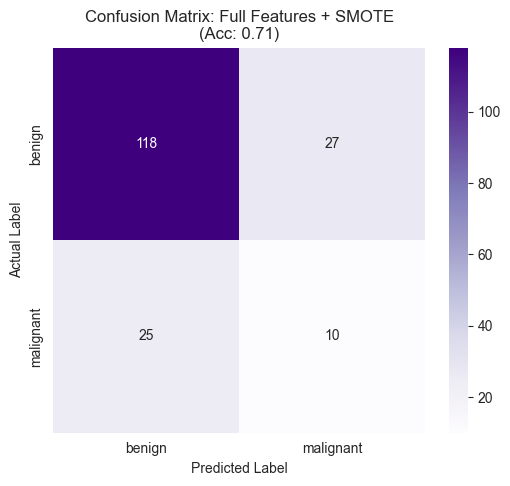

In [165]:
print("--- SKENARIO 3: SVM FULL FEATURES + SMOTE (BASELINE) ---")
print("(Menggunakan seluruh fitur yang ada, dilatih pada data hasil SMOTE)")

# 1. Scaling (StandardScaler)
# PENTING: Kita menggunakan X_train_smote (data training yang sudah diseimbangkan)
# Scaling sangat krusial untuk SVM karena SVM sensitif terhadap jarak (Euclidean distance)

scaler_full = StandardScaler()

# Fit pada Training Data (SMOTE)
X_train_scaled_full = scaler_full.fit_transform(X_train_smote)

# Transform pada Test Data Asli (Gunakan scaler yang sama dari training)
X_test_scaled_full = scaler_full.transform(X_test_raw)

print(f"\nJumlah fitur yang digunakan: {X_train_scaled_full.shape[1]} (Semua Fitur)")

# 2. Training SVM
# Kita gunakan parameter yang sama persis agar perbandingan adil
# class_weight='balanced' tetap dipakai sebagai 'Double Guard' (pengaman ganda)
svm_full = SVC(kernel='rbf', C=1.0, 
               class_weight='balanced', 
               gamma='scale', probability=True, random_state=42)

print("Sedang melatih model SVM Full Features...")
svm_full.fit(X_train_scaled_full, y_train_smote)

# 3. Prediksi
y_pred_full = svm_full.predict(X_test_scaled_full)

# 4. Evaluasi
acc_full = accuracy_score(y_test, y_pred_full)
print(f"\nAkurasi SVM Full Features + SMOTE: {acc_full:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_full, target_names=le.classes_))

# 5. Visualisasi Confusion Matrix
plt.figure(figsize=(6, 5))
cm_full = confusion_matrix(y_test, y_pred_full)
sns.heatmap(cm_full, annot=True, fmt='d', cmap='Purples', 
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title(f'Confusion Matrix: Full Features + SMOTE\n(Acc: {acc_full:.2f})')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.show()

In [166]:
from sklearn.ensemble import RandomForestClassifier

In [167]:
print("--- SKENARIO 1: CHI-SQUARE + RANDOM FOREST (SMOTE) ---")

# A. Scaling (MinMax wajib untuk Chi-Square)
scaler_minmax = MinMaxScaler()
X_train_minmax = scaler_minmax.fit_transform(X_train_smote)
X_test_minmax = scaler_minmax.transform(X_test_raw)

# B. Feature Selection (Top 10)
k_features = 10
chi2_selector = SelectKBest(chi2, k=k_features)

X_train_chi2 = chi2_selector.fit_transform(X_train_minmax, y_train_smote)
X_test_chi2 = chi2_selector.transform(X_test_minmax)

# Tampilkan fitur terpilih
mask = chi2_selector.get_support()
print(f"\nFitur Terpilih: {list(X.columns[mask])}")

# C. Training Random Forest
# n_estimators=100: Jumlah pohon (standar industri)
# class_weight='balanced': Extra proteksi untuk imbalance (meski sudah SMOTE)
rf_chi2 = RandomForestClassifier(n_estimators=100, 
                                 class_weight='balanced', 
                                 random_state=42)

rf_chi2.fit(X_train_chi2, y_train_smote)

# D. Prediksi & Evaluasi
y_pred_chi2_rf = rf_chi2.predict(X_test_chi2)
acc_chi2_rf = accuracy_score(y_test, y_pred_chi2_rf)

print(f"\nAkurasi RF (Chi-Square): {acc_chi2_rf:.4f}")
print(classification_report(y_test, y_pred_chi2_rf, target_names=le.classes_))

--- SKENARIO 1: CHI-SQUARE + RANDOM FOREST (SMOTE) ---

Fitur Terpilih: ['std_H', 'std_V', 'area', 'glcm_ASM', 'hist_H_bin_3', 'hist_H_bin_4', 'hist_H_bin_5', 'hist_S_bin_0', 'hist_V_bin_1', 'hist_V_bin_2']

Akurasi RF (Chi-Square): 0.7611
              precision    recall  f1-score   support

      benign       0.83      0.88      0.86       145
   malignant       0.35      0.26      0.30        35

    accuracy                           0.76       180
   macro avg       0.59      0.57      0.58       180
weighted avg       0.74      0.76      0.75       180



In [168]:
print("--- SKENARIO 2: PCA + RANDOM FOREST (SMOTE) ---")

# A. Scaling (StandardScaler untuk PCA)
scaler_std = StandardScaler()
X_train_std = scaler_std.fit_transform(X_train_smote)
X_test_std = scaler_std.transform(X_test_raw)

# B. Feature Extraction (PCA 95%)
pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

print(f"\nKomponen PCA: {pca.n_components_}")

# C. Training Random Forest
rf_pca = RandomForestClassifier(n_estimators=100, 
                                class_weight='balanced', 
                                random_state=42)

rf_pca.fit(X_train_pca, y_train_smote)

# D. Prediksi & Evaluasi
y_pred_pca_rf = rf_pca.predict(X_test_pca)
acc_pca_rf = accuracy_score(y_test, y_pred_pca_rf)

print(f"\nAkurasi RF (PCA): {acc_pca_rf:.4f}")
print(classification_report(y_test, y_pred_pca_rf, target_names=le.classes_))

--- SKENARIO 2: PCA + RANDOM FOREST (SMOTE) ---

Komponen PCA: 29

Akurasi RF (PCA): 0.7444
              precision    recall  f1-score   support

      benign       0.82      0.87      0.85       145
   malignant       0.30      0.23      0.26        35

    accuracy                           0.74       180
   macro avg       0.56      0.55      0.55       180
weighted avg       0.72      0.74      0.73       180



--- SKENARIO 3: FULL FEATURES + RANDOM FOREST (SMOTE) ---

Akurasi RF (Full Features): 0.7889
              precision    recall  f1-score   support

      benign       0.84      0.91      0.87       145
   malignant       0.43      0.29      0.34        35

    accuracy                           0.79       180
   macro avg       0.64      0.60      0.61       180
weighted avg       0.76      0.79      0.77       180


Top 5 Fitur Paling Penting (Gini Importance):
1. solidity (0.0289)
2. hist_V_bin_0 (0.0277)
3. hog_var (0.0268)
4. hist_H_bin_4 (0.0267)
5. hist_V_bin_2 (0.0266)


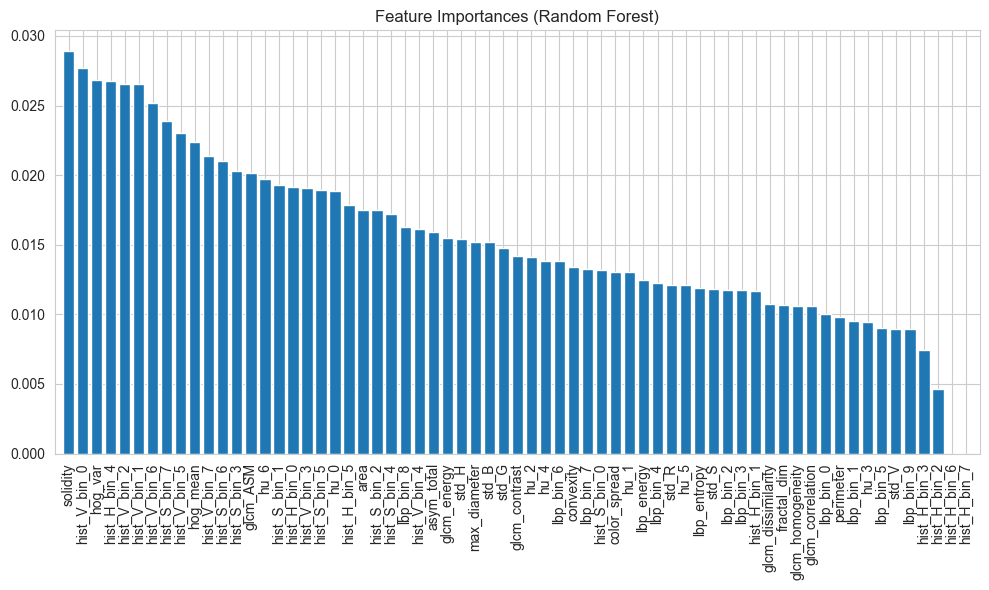

In [169]:
print("--- SKENARIO 3: FULL FEATURES + RANDOM FOREST (SMOTE) ---")

# A. Scaling
# Sebenarnya RF tidak butuh scaling, tapi kita lakukan biar konsisten pipeline-nya
scaler_full = StandardScaler()
X_train_full = scaler_full.fit_transform(X_train_smote)
X_test_full = scaler_full.transform(X_test_raw)

# B. Training Random Forest
rf_full = RandomForestClassifier(n_estimators=100, 
                                 class_weight='balanced', 
                                 random_state=42)

rf_full.fit(X_train_full, y_train_smote)

# C. Prediksi & Evaluasi
y_pred_full_rf = rf_full.predict(X_test_full)
acc_full_rf = accuracy_score(y_test, y_pred_full_rf)

print(f"\nAkurasi RF (Full Features): {acc_full_rf:.4f}")
print(classification_report(y_test, y_pred_full_rf, target_names=le.classes_))

# --- BONUS: FITUR APA YANG PALING PENTING MENURUT RF? ---
# Random Forest bisa memberitahu kita fitur mana yang paling berguna membedakan kanker
importances = rf_full.feature_importances_
indices = np.argsort(importances)[::-1] # Urutkan dari terbesar

print("\nTop 5 Fitur Paling Penting (Gini Importance):")
for f in range(5):
    print(f"{f+1}. {X.columns[indices[f]]} ({importances[indices[f]]:.4f})")

# Visualisasi Feature Importance
plt.figure(figsize=(10, 6))
plt.title("Feature Importances (Random Forest)")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.tight_layout()
plt.show()

=== PERFORMA RANDOM FOREST ===


,Metode,Akurasi,F1-Score (Macro)
0,Chi-Square + RF,76.11%,57.56%
1,PCA + RF,74.44%,55.19%
2,Full Features + RF,78.89%,60.95%


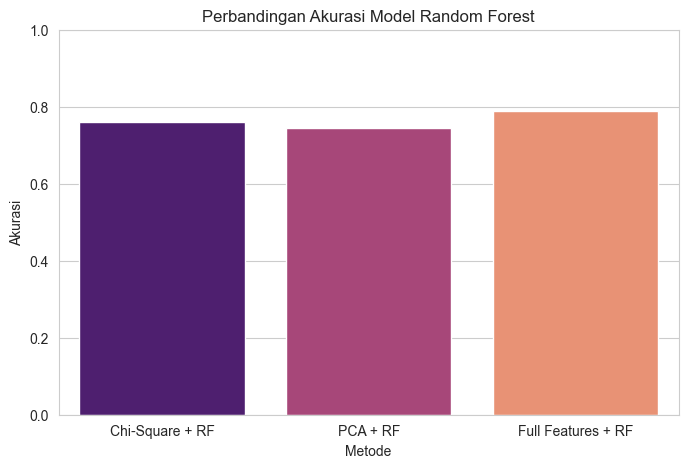

In [170]:
results_rf = {
    'Metode': ['Chi-Square + RF', 'PCA + RF', 'Full Features + RF'],
    'Akurasi': [acc_chi2_rf, acc_pca_rf, acc_full_rf],
    'F1-Score (Macro)': [
        classification_report(y_test, y_pred_chi2_rf, output_dict=True)['macro avg']['f1-score'],
        classification_report(y_test, y_pred_pca_rf, output_dict=True)['macro avg']['f1-score'],
        classification_report(y_test, y_pred_full_rf, output_dict=True)['macro avg']['f1-score']
    ]
}

df_results_rf = pd.DataFrame(results_rf)
df_results_rf['Akurasi'] = df_results_rf['Akurasi'].apply(lambda x: f"{x:.2%}")
df_results_rf['F1-Score (Macro)'] = df_results_rf['F1-Score (Macro)'].apply(lambda x: f"{x:.2%}")

print("=== PERFORMA RANDOM FOREST ===")
display(df_results_rf)

# PERBAIKAN PLOTTING
plt.figure(figsize=(8, 5))

# Solusi: Masukkan data langsung ke x (list nama) dan y (list angka akurasi asli)
# Jangan gunakan string 'Metode', tapi gunakan df_results_rf['Metode']
sns.barplot(x=df_results_rf['Metode'], y=[acc_chi2_rf, acc_pca_rf, acc_full_rf], palette='magma')

plt.ylim(0, 1.0)
plt.title("Perbandingan Akurasi Model Random Forest")
plt.ylabel("Akurasi")
plt.show()